## 1. Introduction

**Name:** Simarjit Singh GH1037512

**Course:** M505A Intro to Machine Learning 

**Title:** Creating ML pipeline to predict Ethereum Price 


**Business Problem:**

Ethereum's price prediction is a crucial task for investors, traders, and financial analysts. Predicting crypto prices accurately can help in making informed decisions about buying, selling, or holding stocks. This project aims to develop a machine-learning model that can predict the closing price of Ethereum based on historical crypto data.

**Why is This Important?**

1. **Informed Investment Decisions:** Investors can use these predictions to determine when to enter or exit the market.

2. **Risk Management:** Accurate forecasts can help in minimizing losses by identifying trends before they happen.

3. **Market Strategy:** Stock traders can optimise their buying and selling strategies based on predictions.

By leveraging historical crypto price data, we aim to build a predictive model that forecasts the closing price of a crypto based on previous trading data.

### Dataset Overview

The dataset consists of historical stock prices with the following columns:

* **Date:** The date on which the stock data was recorded.

* **Ticker:** The stock symbol for the company.

* **Open:** Opening price of the stock.

* **High:** The highest price reached.

* **Low:** The lowest price reached.

* **Close:** The closing price of the stock (target variable).

### Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

### Reading the Dataset

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Simarjit1303/Projects/refs/heads/main/Machine%20Learning/Ethereum%20Price%20Prediction/ETH.csv')
df.head()

,ticker,date,open,high,low,close
0,ETH,2015-08-07,3.0,3.0,3.0000,3.00
1,ETH,2015-08-08,3.0,3.0,1.2000,1.20
2,ETH,2015-08-09,1.2,1.2,1.2000,1.20
3,ETH,2015-08-10,1.2,1.2,1.2000,1.20
4,ETH,2015-08-11,1.2,1.2,0.6504,0.99


### Splitting the data

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((2771, 6), (693, 6))

## 2. Exploratory Data Analysis(EDA)

Missing values:
ticker    0
date      0
open      0
high      0
low       0
close     0
dtype: int64


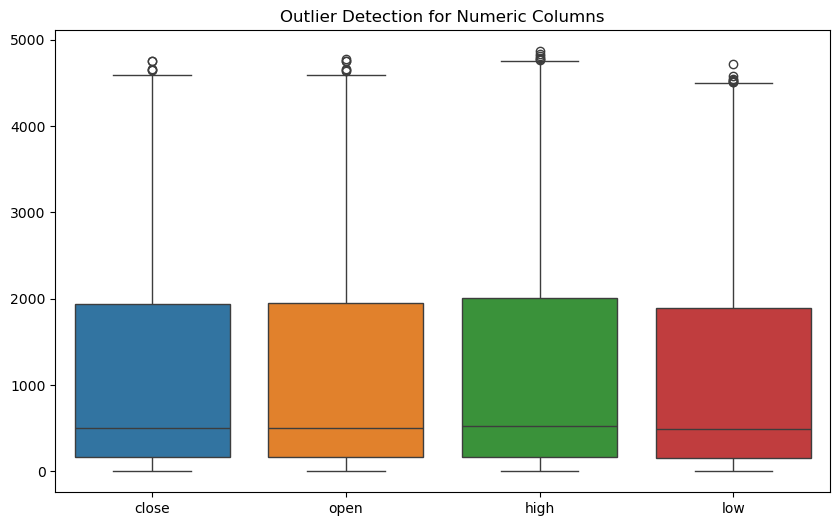

In [4]:
print(f"Missing values:\n{df.isnull().sum()}")  
df_train = df_train.drop(['ticker','date'],axis=1) 
df_train.drop_duplicates(inplace=True)   
df_train.reset_index(drop=True,inplace=True)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_train[['close', 'open', 'high', 'low']])
plt.title('Outlier Detection for Numeric Columns')
plt.show()

* **Handling Missing Values:** Checked for null values and dropped unnecessary columns ('ticker' and 'date').
* **Figure:** Using the Boxplot I checked for outliers in our dataset and as the figure shows there are some outliers in my data which will be solved later.

(2761, 4)


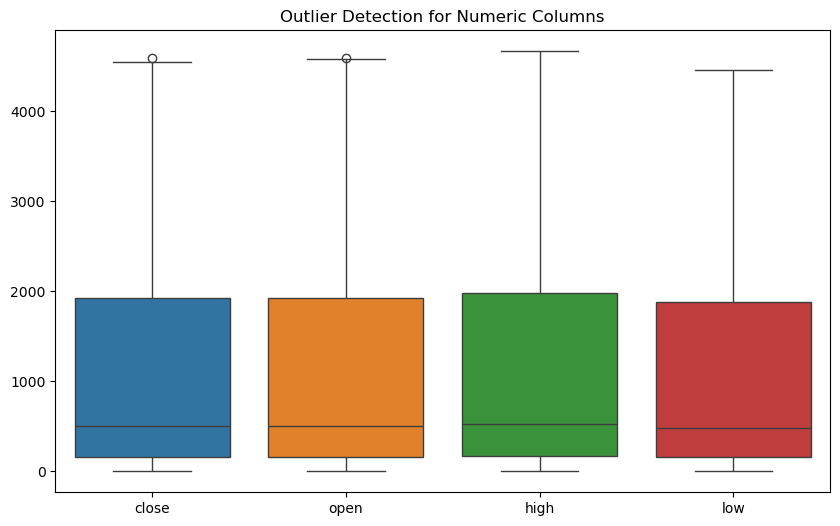

In [5]:
Q1 = df_train[['close','open', 'high', 'low']].quantile(0.25)
Q3 = df_train[['close','open', 'high', 'low']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_train = df_train[(df_train[['close','open', 'high', 'low']] >= lower_bound).all(axis = 1) & (df_train[['close','open', 'high', 'low']] <= upper_bound).all(axis = 1)]
print(df_train.shape)

plt.figure(figsize=(10,6))
sns.boxplot(data=df_train[['close', 'open', 'high', 'low']])
plt.title('Outlier Detection for Numeric Columns')
plt.show()

* **Outlier Removal using IQR (Interquartile Range) Method:** Removed extreme values in open, high, low, and close columns to ensure data consistency.

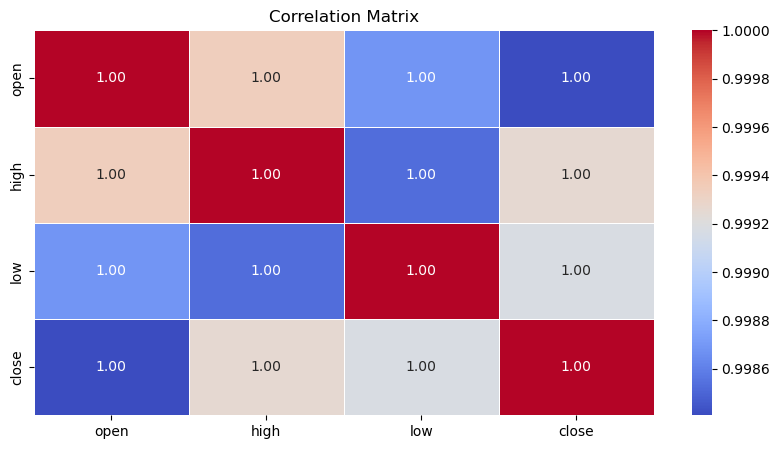

In [6]:
corr_matrix = df_train.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

* **Correlation Matrix:** A heatmap revealed strong correlations between open, high, low, and close prices, justifying the use of past prices as features.

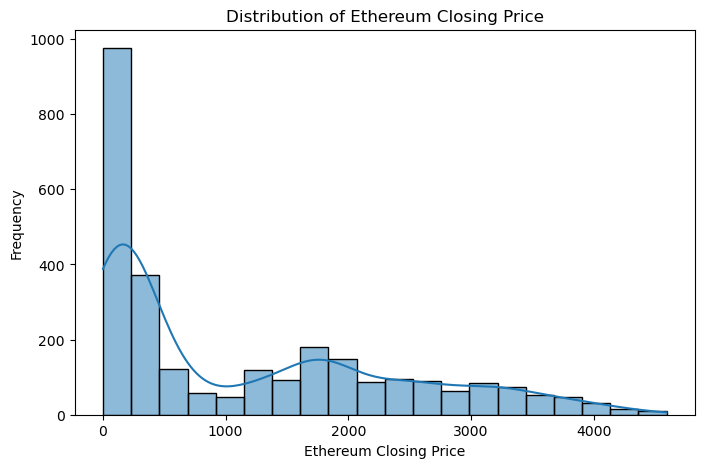

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(df_train['close'], kde=True, bins=20)
plt.title('Distribution of Ethereum Closing Price')
plt.xlabel('Ethereum Closing Price')
plt.ylabel('Frequency')
plt.show()

* **Price Distribution:** The distribution of closing prices was visualized using a histogram, showing a slightly skewed distribution.

## 3. Data Preprocessing

In [8]:
Q1 = df_test[['close','open', 'high', 'low']].quantile(0.25)
Q3 = df_test[['close','open', 'high', 'low']].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_test = df_test[(df_test[['close','open', 'high', 'low']] >= lower_bound).all(axis = 1) & (df_test[['close','open', 'high', 'low']] <= upper_bound).all(axis = 1)]

#Set 1: Using past closing prices (shifting by 1, 2, 3 days)
df_train['close_shift_1'] = df_train['close'].shift(1)
df_test['close_shift_1'] = df_test['close'].shift(1)
df_train['close_shift_2'] = df_train['close'].shift(2)
df_test['close_shift_2'] = df_test['close'].shift(2)
df_train['close_shift_3'] = df_train['close'].shift(3)
df_test['close_shift_3'] = df_test['close'].shift(3)

# Set 2: Percentage change in closing prices (returns)
df_train['pct_change_1'] = df_train['close'].pct_change(1)
df_test['pct_change_1'] = df_test['close'].pct_change(1)
df_train['pct_change_2'] = df_train['close'].pct_change(2)
df_test['pct_change_2'] = df_test['close'].pct_change(2)
df_train['pct_change_3'] = df_train['close'].pct_change(3)
df_test['pct_change_3'] = df_test['close'].pct_change(3)

# Set 3: Moving averages (window size of 7)
df_train['MA_7'] = df_train['close'].rolling(window=7).mean()
df_test['MA_7'] = df_test['close'].rolling(window=7).mean()

# Set 4: Bollinger Bands (20 days window)
df_train['bollinger_upper'] = df_train['close'].rolling(window=20).mean() + (df_train['close'].rolling(window=20).std() * 2)
df_test['bollinger_upper'] = df_test['close'].rolling(window=20).mean() + (df_test['close'].rolling(window=20).std() * 2)
df_train['bollinger_lower'] = df_train['close'].rolling(window=20).mean() - (df_train['close'].rolling(window=20).std() * 2)
df_test['bollinger_lower'] = df_test['close'].rolling(window=20).mean() - (df_test['close'].rolling(window=20).std() * 2)

# Drop null values (due to shifting and rolling)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)
df_test.drop_duplicates(inplace=True)   
df_test.reset_index(drop=True,inplace=True)

In [9]:
X_train = df_train.drop(['open', 'high', 'low', 'close'],axis=1)
y_train = df_train['close']
X_test = df_test.drop(['open', 'high', 'low', 'close','ticker','date'],axis=1)
y_test = df_test['close']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2742, 9) (2742,)
(672, 9) (672,)


* **Shifted Closing Prices:** Added past closing prices as new features to capture trends.

* **Percentage Changes:** Calculated percentage change over different time intervals.

* **Moving Averages:** Included a 7-day moving average to smooth out price fluctuations.

* **Bollinger Bands:** Used a 20-day rolling window to measure stock volatility.

* **Data Preprocessing:** drooping and declaring data columns as needed.

## 4. Feature Engineering

In [10]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 5. Model Training, Testing and Evaluation

In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Support Vector Regressor": SVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge()
}

predictions = {name: model.fit(X_train_scaled, y_train).predict(X_test_scaled) for name, model in models.items()}

r2_scores = {name: r2_score(y_test, pred) for name, pred in predictions.items()}

r2_results_df = pd.DataFrame(list(r2_scores.items()), columns=["Model Name", "R² Score"])
print(r2_results_df)


                    Model Name  R² Score
0            Linear Regression  0.313157
1     Support Vector Regressor -0.210290
2      Decision Tree Regressor  0.821350
3      Random Forest Regressor  0.947735
4            XGBoost Regressor  0.968714
5  Gradient Boosting Regressor  0.941721
6             Lasso Regression  0.312302
7             Ridge Regression  0.313100


**Why Regression?**

Since the goal is to predict a continuous numerical value (closing stock price), regression models are the best fit. Several models were tested, including:

1. Linear Regression

2. Support Vector Regressor (SVR)

3. Decision Tree Regressor

4. Random Forest Regressor

5. Gradient Boosting Regressor

6. XGBoost Regressor

**After comparing their performance using R-squared (R²), the XGBoost Regressor was chosen as the final model due to its superior predictive accuracy and ability to handle complex patterns.**

## 6. Hyperparameter Tuning

In [12]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}


## 7. XGBoost Regression Evaluation Before and After Hyperparameter Tuning

In [13]:
r2_score_before = r2_scores["XGBoost Regressor"]
r2_score_after = r2_score(y_test, best_xgb.predict(X_test_scaled))

print("\nXGBoost R² Score Comparison:")
print(f"{'Before Tuning:':<20} {r2_score_before:.4f}")
print(f"{'After Tuning:':<20} {r2_score_after:.4f}")



XGBoost R² Score Comparison:
Before Tuning:       0.9687
After Tuning:        0.9802


## 8. Business Question
Q: What will the Ethereum's closing price for today, given that the previous day's closing price is known?

This question is critical for investors and traders who want to forecast the stock price trend for the next day. By using historical price data, this model helps in making data-driven investment decisions.

In [14]:
def predict_closing_price(previous_day_data):
    return best_xgb.predict(previous_day_data)
    

latest_data = X_test_scaled[-1].reshape(1, -1)
predicted_closing_price = predict_closing_price(latest_data)

print(f"Predicted closing price for today: {predicted_closing_price[0]:.2f}")

Predicted closing price for today: 2291.34


## 9. Conclusion

This project successfully demonstrated an end-to-end machine learning pipeline for crypto price prediction using the XGBoost Regressor. Hyperparameter tuning significantly improved the model’s predictive accuracy, and the insights gained can be used by investors and traders to make informed financial decisions based on data-driven crypto forecasts.